## カメラキャリブレーション サンプルプログラム

## 概要
本notebookはカメラキャリブレーションにおける基本的な操作である，
+ [内部キャリブレーション](#内部キャリブレーション)
+ [外部キャリブレーション](#外部キャリブレーション)

のサンプルプログラムです．　

## 利用方法
各プログラムの基本的な操作方法は以下のとおりです．
1. [インポートライブラリおよび関数](#インポートライブラリおよび関数)を実行する． (上部の▶| Runを押す) 
1. 各目的のプログラム([内部キャリブレーション](#内部キャリブレーション)/[外部キャリブレーション](#外部キャリブレーション))を実行する．

(外部キャリブレーションは事前に内部キャリブレーションのプログラムを実行しておいてください)

## インポートライブラリおよび関数

In [110]:
# ===== インポートライブラリ =====
import sys, os, cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

# ===== 関数 =====
def plotCamera(ax, R, t, c, scale):
    ps_c = np.array(([0,0,0], [1,1,3], [1,-1,3], [-1,-1,3], [-1,1,3]))
    ps_w = np.zeros((ps_c.shape))

    for i_p in range(ps_c.shape[0]):
        ps_w[i_p] = R.dot(scale*ps_c[i_p]) + t

    L01 = np.array([ps_w[0], ps_w[1]])
    L02 = np.array([ps_w[0], ps_w[2]])
    L03 = np.array([ps_w[0], ps_w[3]])
    L04 = np.array([ps_w[0], ps_w[4]])
    L1234 = np.array([ps_w[1], ps_w[2], ps_w[3], ps_w[4], ps_w[1]])
    
    ax.plot(L01[:,0], L01[:,1], L01[:,2], "-", color=c)
    ax.plot(L02[:,0], L02[:,1], L02[:,2], "-", color=c)
    ax.plot(L03[:,0], L03[:,1], L03[:,2], "-", color=c)
    ax.plot(L04[:,0], L04[:,1], L04[:,2], "-", color=c)
    ax.plot(L1234[:,0], L1234[:,1], L1234[:,2], "-", color=c)


## 内部キャリブレーション

内部キャリブレーション用のサンプルプログラムです．
各種パラメータを設定の上ご利用ください．

内部行列 ：  [[1.32931637e+03 0.00000000e+00 9.57857318e+02]
 [0.00000000e+00 1.32931637e+03 5.47353253e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
歪みパラメータ :  [[ 0.0052289  -0.01161532  0.0029297   0.00017352  0.0003208 ]]


<IPython.core.display.Javascript object>


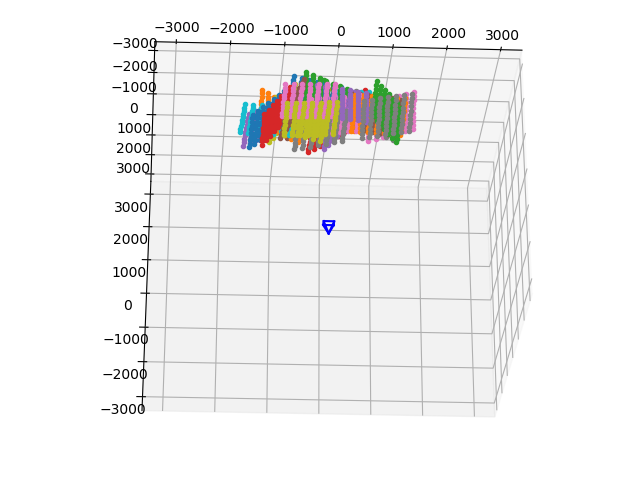

In [113]:
# ===== キャリブレーション用設定パラメータ =====
row = 7 # チェスパターンのコーナーの行数
col = 10 # チェスパターンのコーナーの列数
size = 160 # チェスパターンのコーナー間の距離
data_dir = "./data" # キャリブレーション用画像のデータフォルダ
suffix = "png" # キャリブレーション用画像の拡張子
plot_mode = 0 # 0: カメラ固定， 1: チェスボード固定　(結果プロット用パラメータ)
plot_range = 4000 # プロットする範囲 (-plot_range ~ plot_range, 結果プロット用パラメータ)
camera_size = 100 # プロット時のカメラのサイズ (結果プロット用パラメータ)
# =================================

corner_num = (col, row) # チェスパターンのコーナーの数

###  XW: チェスボードの三次元座標値＠世界座標系を用意
X_W = np.empty([row * col, 3], dtype=np.float32)
for i_row in range(0, row):
    for i_col in range(0, col):
        X_W[i_row*col+i_col] = np.array([size*i_col, size*i_row, 0], dtype=np.float32)

Xs_W = []
xs_I = []

### xI: チェスボードの二次元座標値＠画像座標系を用意．（画像から検出する）
glob_string = "%s/*.%s" % (data_dir, suffix) 
for image_path in glob(glob_string): # 入力画像のリスト
    image = cv2.imread(image_path, 0) # 画像の読み込み
    found, x_I = cv2.findChessboardCorners(image, corner_num) # チェスコーナーの検出

    if found:# コーナー検出成功
        term = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_COUNT, 30, 0.1)
        x_I_sub = cv2.cornerSubPix(image, x_I, (5,5), (-1,-1), term) # サブピクセル精度でコーナー位置を推定
        Xs_W.append(X_W)
        xs_I.append(x_I_sub)       
    else: #コーナー検出失敗
        print("Detection failed :", image_path)
        continue 

### 内部キャリブレーション (内部パラメータの推定に用いたチェスボードに対する外部パラメータも求めている)
rep, K, d, rvec, tvec = cv2.calibrateCamera(Xs_W, xs_I, (image.shape[1], image.shape[0]), None, None, flags=cv2.CALIB_FIX_ASPECT_RATIO)

# 内部パラメータ
print("内部行列 ： ", K)
print("歪みパラメータ : ", d)

# 結果のプロット
fig_in = plt.figure()
ax_in = Axes3D(fig_in)

ax_in.set_xlim(-plot_range, plot_range)
ax_in.set_ylim(-plot_range, plot_range)
ax_in.set_zlim(-plot_range, plot_range)

if plot_mode == 0: # カメラ固定．　カメラ座標系で描画
    
    plotCamera(ax_in, np.eye(3), np.zeros((1,3)), "b", camera_size) # カメラの描画＠原点
    
    for i_ex in range(len(rvec)):
        X_C = np.zeros((X_W.shape))
        for i_x in range(X_W.shape[0]):
            R_w2c = cv2.Rodrigues(rvec[i_ex])[0] # ベクトル形式 -> 行列形式に変換
            t_w2c = tvec[i_ex].reshape(3)
            X_C[i_x,:] = R_w2c.dot(X_W[i_x,:]) + t_w2c # 世界座標系からカメラ座標系に変換    
                
        ax_in.plot(X_C[:,0], X_C[:,1], X_C[:,2], ".") # チェスボードの描画
        
elif plot_mode == 1: # チェスボード固定．　チェスボード（世界）座標系で描画
    
    for i_ex in range(len(rvec)):
        R_c2w = np.linalg.inv(cv2.Rodrigues(rvec[i_ex])[0]) #　世界座標系におけるカメラの向き
        t_c2w = -R_c2w.dot(tvec[i_ex]).reshape((1,3)) # 世界座標系におけるカメラの位置
        
        plotCamera(ax_in, R_c2w, t_c2w, "b", camera_size)
        
    ax_in.plot(X_W[:,0], X_W[:,1], X_W[:,2], ".")



## 外部キャリブレーション

内部キャリブレーション用のサンプルプログラムです．
各種パラメータを設定の上ご利用ください．　

（内部パラメータを利用するため，事前に内部キャリブレーションのサンプルプログラムを実行しておいてください．）

<IPython.core.display.Javascript object>


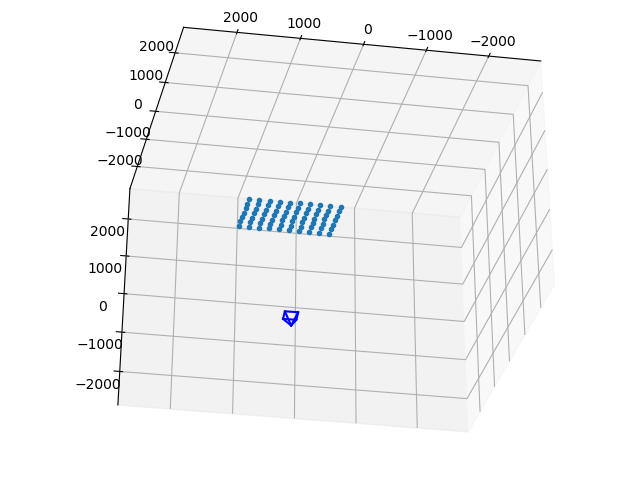

In [116]:
# ===== キャリブレーション用パラメータ =====
# 今回は内部キャリブレーションと同じ参照物体（チェスボードなど）を利用する
path_image = "./data/00000000.png" # 外部キャリブレーション用画像パス
plot_range = 4000 # プロットする範囲 (-plot_range ~ plot_range, 結果プロット用パラメータ)
camera_size = 100 # プロット時のカメラのサイズ (結果プロット用パラメータ)
# ==============================

ex_image = cv2.imread(path_image, 0) # 画像の読み込み
found, x_I = cv2.findChessboardCorners(ex_image, corner_num) # チェスコーナーの検出

if found:
    term = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_COUNT,30,0.1) 
    x_I_sub = cv2.cornerSubPix(ex_image, x_I, (5,5), (-1,-1), term) # サブピクセル精度で検出

    ret, rvec, tvec = cv2.solvePnP(X_W, x_I, K, d) # PnP問題を解いて外部パラメータを推定

    # 結果の表示
    fig_ex = plt.figure()
    ax_ex = Axes3D(fig_ex)

    ax_ex.set_xlim(-plot_range, plot_range)
    ax_ex.set_ylim(-plot_range, plot_range)
    ax_ex.set_zlim(-plot_range, plot_range)

    R_w2c = cv2.Rodrigues(rvec)[0] # PnPで求まるR,tは XC = R * XW + tを満たす
    R_c2w = np.linalg.inv(R_w2c) #　世界座標系におけるカメラの向き　
    t_c2w = -R_c2w.dot(tvec).reshape((1,3)) # 世界座標系におけるカメラの位置
    
    plotCamera(ax_ex, R_c2w, t_c2w, "b", camera_size)

    ax_ex.plot(X_W[:,0], X_W[:,1], X_W[:,2], ".")    
